In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/brain-mri-dataset.zip", 'r')
zip_ref.extractall("/content/dataset")
zip_ref.close()

In [3]:
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [4]:
train_path = './dataset/Training'

filepaths = []
labels = []

directories = os.listdir(train_path) # store list of disease types
for directory in directories:
    f_path = os.path.join(train_path, directory) # join filepath with tumor name to get full path
    filelists = os.listdir(f_path) # get all files in list in current f_path
    filepaths.extend([os.path.join(f_path, file) for file in filelists]) # in current f_path add all files in filelist of it
    labels.extend([directory] * len(filelists)) # add label to current directory, number of labels equal to len(filelists)

train_frame = pd.DataFrame({'filepaths': filepaths, 'label': labels})

In [5]:
test_path = './dataset/Testing'

filepaths = []
labels = []

directories = os.listdir(test_path)
for directory in directories:
    f_path = os.path.join(test_path, directory)
    filelists = os.listdir(f_path)
    filepaths.extend([os.path.join(f_path, file) for file in filelists])
    labels.extend([directory] * len(filelists))

test_frame = pd.DataFrame({'filepaths': filepaths, 'label': labels})

In [6]:
img_size = (300, 300)
batch_size = 16

tr_gen = ImageDataGenerator(rotation_range=5,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            horizontal_flip=True)

ts_gen = ImageDataGenerator()

In [7]:

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []
fold_losses = []

for fold, (train_index, val_index) in enumerate(kf.split(train_frame)):
    print(f"Fold {fold + 1}")

    train_df = train_frame.iloc[train_index]
    valid_df = train_frame.iloc[val_index]

    train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='label', target_size=img_size,
                                           class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

    valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='label', target_size=img_size,
                                           class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

    base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights='imagenet',
                                                                   input_shape=(300, 300, 3), pooling='max')
    model = Sequential([
        base_model,
        BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        Dense(256, kernel_regularizer=regularizers.l2(0.02), activation='relu'),
        Dropout(rate=0.4, seed=42),
        Dense(len(train_gen.class_indices), activation='softmax')
    ])

    model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(train_gen, validation_data=valid_gen, epochs=8, shuffle=True, verbose=1)

    fold_accuracies.append(history.history['val_accuracy'][-1])
    fold_losses.append(history.history['val_loss'][-1])


avg_accuracy = np.mean(fold_accuracies)
avg_loss = np.mean(fold_losses)

var_accuracy = np.var(fold_accuracies)
var_loss = np.var(fold_losses)

print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Variance in Accuracy: {var_accuracy:.4f}")
print(f"Average Loss: {avg_loss:.4f}")
print(f"Variance in Loss: {var_loss:.4f}")

Fold 1
Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
43941136/43941136 [==============================] - 0s 0us/step
Epoch 1/8
286/286 [==============================] - 240s 613ms/step - loss: 6.4866 - accuracy: 0.8615 - val_loss: 4.2420 - val_accuracy: 0.9563
Epoch 2/8
286/286 [==============================] - 170s 593ms/step - loss: 3.0895 - accuracy: 0.9420 - val_loss: 2.0635 - val_accuracy: 0.9633
Epoch 3/8
286/286 [==============================] - 173s 604ms/step - loss: 1.4827 - accuracy: 0.9661 - val_loss: 0.9793 - val_accuracy: 0.9834
Epoch 4/8
286/286 [==============================] - 162s 564ms/step - loss: 0.7260 - accuracy: 0.9733 - val_loss: 0.4736 - val_accuracy: 0.9860
Epoch 5/8
286/286 [==============================] - 163s 570ms/step - loss: 0.3745 - accuracy: 0.9768 - val_loss: 0.2513 - val_accuracy: 0.9851
Epoch 6/8
286/286 [==============================] - 166s 579ms/step - loss: 0.22

In [9]:
full_train_gen = tr_gen.flow_from_dataframe(train_frame, x_col='filepaths', y_col='label', target_size=img_size,
                                            class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights='imagenet',
                                                               input_shape=(300, 300, 3), pooling='max')
model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(0.02), activation='relu'),
    Dropout(rate=0.4, seed=42),
    Dense(len(full_train_gen.class_indices), activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(full_train_gen, epochs=8, shuffle=True, verbose=1)

test_gen = ts_gen.flow_from_dataframe(test_frame, x_col='filepaths', y_col='label', target_size=img_size,
                                      class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

test_score = model.evaluate(test_gen, steps=len(test_gen), verbose=1)
test_loss, test_accuracy = test_score

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Found 5712 validated image filenames belonging to 4 classes.
Epoch 1/8
357/357 [==============================] - 240s 532ms/step - loss: 6.2155 - accuracy: 0.8746
Epoch 2/8
357/357 [==============================] - 190s 533ms/step - loss: 2.6946 - accuracy: 0.9498
Epoch 3/8
357/357 [==============================] - 190s 532ms/step - loss: 1.1716 - accuracy: 0.9702
Epoch 4/8
357/357 [==============================] - 194s 543ms/step - loss: 0.5185 - accuracy: 0.9765
Epoch 5/8
357/357 [==============================] - 193s 539ms/step - loss: 0.2563 - accuracy: 0.9809
Epoch 6/8
357/357 [==============================] - 192s 536ms/step - loss: 0.1542 - accuracy: 0.9828
Epoch 7/8
357/357 [==============================] - 192s 538ms/step - loss: 0.1041 - accuracy: 0.9849
Epoch 8/8
357/357 [==============================] - 192s 536ms/step - loss: 0.0842 - accuracy: 0.9860
Found 1311 validated image filenames belonging to 4 classes.
82/82 [==============================] - 14s 133ms/ste

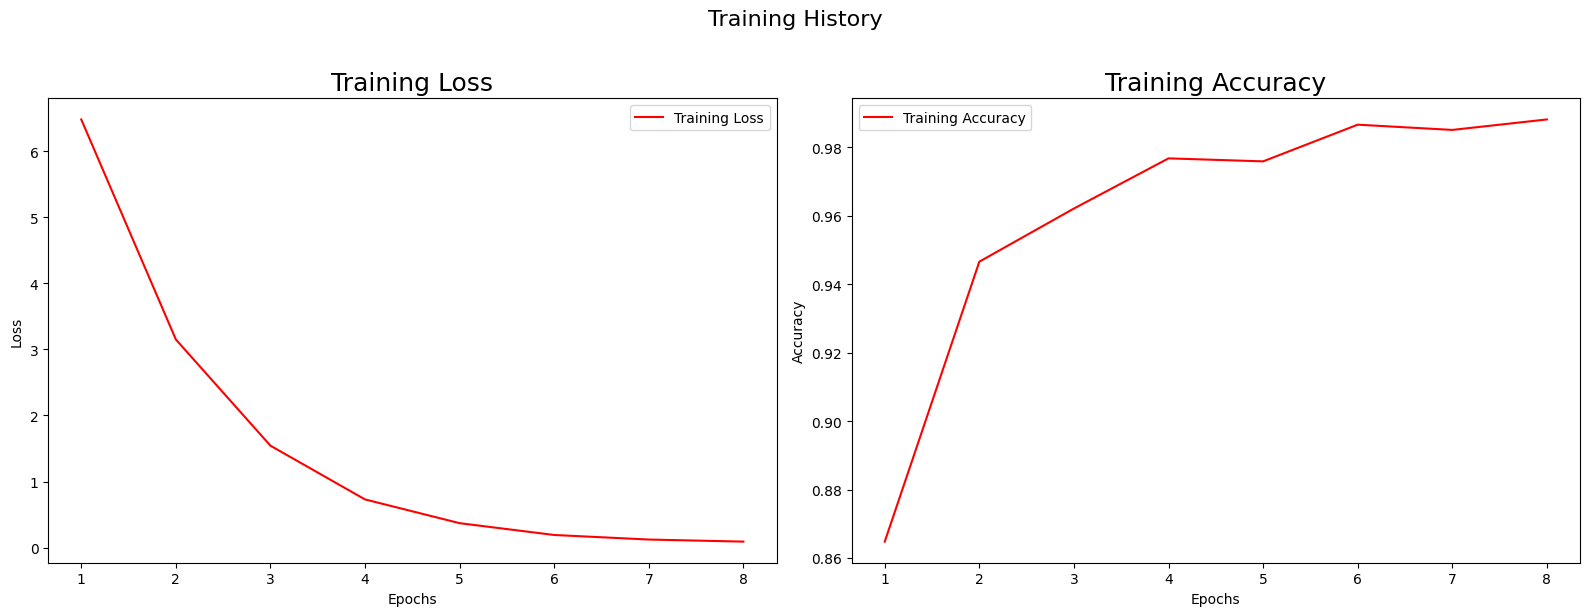

In [12]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

Epochs = [i + 1 for i in range(len(train_acc))]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Training History', fontsize=16, y=1.02)

axes[0].plot(Epochs, train_loss, 'r', label='Training Loss')
axes[0].set_title('Training Loss', fontsize=18)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(Epochs, train_acc, 'r', label='Training Accuracy')
axes[1].set_title('Training Accuracy', fontsize=18)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

82/82 [==============================] - 12s 102ms/step


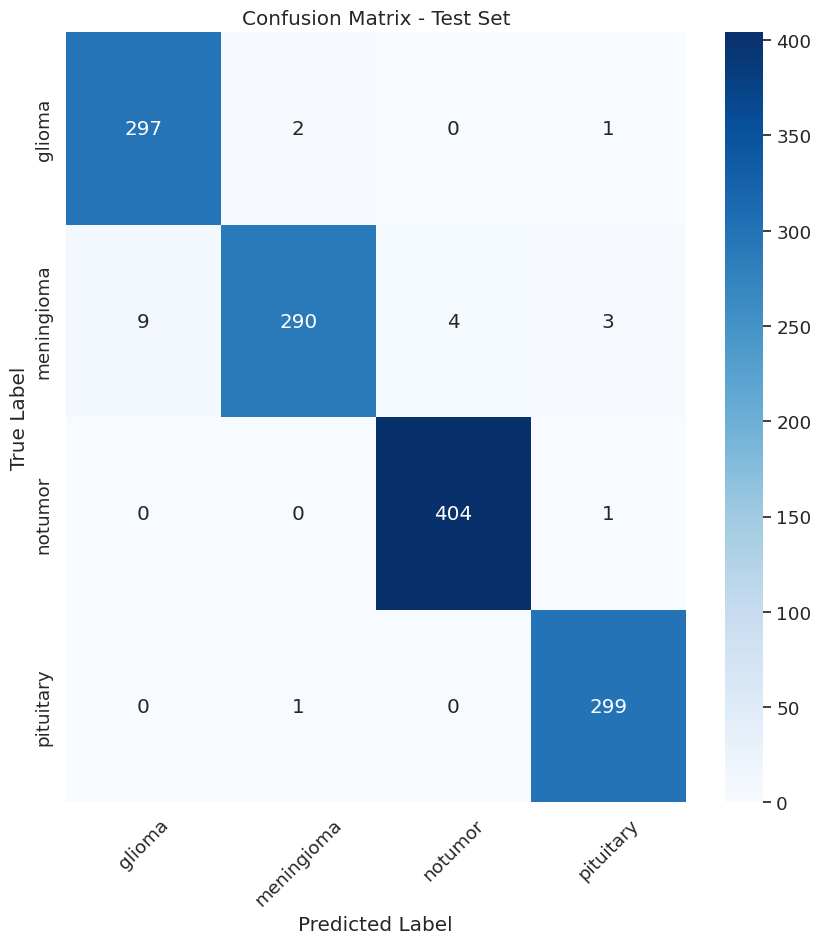

              precision    recall  f1-score   support

      glioma       0.97      0.99      0.98       300
  meningioma       0.99      0.95      0.97       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.98      1.00      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



In [13]:
test_preds = model.predict(test_gen, steps=len(test_gen), verbose=1)
test_y_pred = np.argmax(test_preds, axis=1)

test_cm = confusion_matrix(test_gen.classes, test_y_pred)
test_classes = list(test_gen.class_indices.keys())

plt.figure(figsize=(10, 10))
sns.set(font_scale=1.2)
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_classes, yticklabels=test_classes)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.show()

print(classification_report(test_gen.classes, test_y_pred, target_names=test_classes))